In [2]:
import h5py
import numpy as np
L = h5py.File(conf.labelfile)
print(L['pts'])

# jj = np.array(L['pts'])

<HDF5 dataset "pts": shape (5348, 4, 1, 2), type "<f8">


In [3]:
import janLegConfig as conf
reload(conf)
import multiResData
reload(multiResData)

multiResData.createDB(conf)

Done 0 of 13 movies, count:583 val:0
Done 1 of 13 movies, count:1747 val:0
Done 2 of 13 movies, count:1747 val:168
Done 3 of 13 movies, count:2014 val:168
Done 4 of 13 movies, count:3395 val:168
Done 5 of 13 movies, count:4118 val:168
Done 6 of 13 movies, count:4652 val:168
Done 7 of 13 movies, count:4652 val:1042
Done 8 of 13 movies, count:4869 val:1042
Done 9 of 13 movies, count:4869 val:1904
Done 10 of 13 movies, count:5225 val:1904
Done 11 of 13 movies, count:5636 val:1904
Done 12 of 13 movies, count:7009 val:1904
7009,1904 number of pos examples added to the db and valdb


In [3]:
import os
import lmdb
import janLegConfig as conf

lmdbfilename =os.path.join(conf.cachedir,conf.trainfilename)
env = lmdb.open(lmdbfilename, readonly = True)
print(env.stat())

{'branch_pages': 8L, 'leaf_pages': 190L, 'overflow_pages': 76262L, 'psize': 4096L, 'depth': 3L, 'entries': 4486L}


In [4]:
cursor = env.begin().cursor()

In [6]:
import multiResData
import multiPawTools
import matplotlib.pyplot as plt
reload(multiResData)

ii,locs = multiPawTools.readLMDB(cursor,2,conf.imsz,multiResData)
locs = multiResData.sanitizelocs(locs)

In [7]:
np.isnan(locs[1][0][0])

False

In [1]:
plt.figure(figsize=(8,8))
import matplotlib.pyplot as plt
plt.gray()
plt.imshow(ii[0,0,:,:])

print(locs[0])

xlocs,ylocs  = zip(*locs[0])
plt.scatter(xlocs,ylocs,hold=True)

NameError: name 'plt' is not defined

In [1]:
import multiResTrain
reload(multiResTrain)
import janLegConfig as conf
reload(conf)

multiResTrain.trainBase(conf)

Iter 0
  Training Loss= 8037.154785, Minibatch Loss= 8037.176758
  Read Time:0.02, Proc Time:0.11, Opt Time:18.74
Saved state to /home/mayank/work/tensorflow/cachejanLeg/janLeg_0.ckpt
Iter 30
  Training Loss= 552.475647, Minibatch Loss= 554.136032
  Read Time:0.01, Proc Time:0.10, Opt Time:19.23
Iter 60
  Training Loss= 98.681816, Minibatch Loss= 98.375580
  Read Time:0.01, Proc Time:0.09, Opt Time:19.40
Iter 90
  Training Loss= 87.474701, Minibatch Loss= 87.325853
  Read Time:0.01, Proc Time:0.09, Opt Time:19.35
Iter 120
  Training Loss= 75.480087, Minibatch Loss= 75.418005
  Read Time:0.01, Proc Time:0.09, Opt Time:19.31
Iter 150
  Training Loss= 65.042633, Minibatch Loss= 65.037659
  Read Time:0.01, Proc Time:0.09, Opt Time:19.25
Iter 180
  Training Loss= 54.344711, Minibatch Loss= 54.365862
  Read Time:0.01, Proc Time:0.09, Opt Time:19.17
Iter 210
  Training Loss= 43.480343, Minibatch Loss= 43.516525
  Read Time:0.01, Proc Time:0.09, Opt Time:19.13
Iter 240
  Training Loss= 34.6382

In [ ]:
import multiResTrain
reload(multiResTrain)
import janLegConfig as conf
reload(conf)

multiResTrain.trainFine(conf)

In [1]:
import scipy.io as sio
import os,sys
sys.path.append('/home/mayank/work/pyutils')
import myutils
import re
import janLegConfig as conf
import shutil

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cv2
import math
import lmdb
import caffe
from random import randint,sample
import pickle
import h5py

'''
Mayank Feb 3 2016
'''

import tensorflow as tf
import os,sys
import tempfile
import copy
sys.path.append('/home/mayank/work/caffe/python')
sys.path.append('/home/mayank/work/pyutils')

import caffe
import lmdb
import caffe.proto.caffe_pb2
from caffe.io import datum_to_array
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import math
import cv2
import numpy as np
import scipy

import multiPawTools
import myutils
from convNetBase import *

# import stephenHeadConfig as conf
import multiResData

import mpld3
mpld3.enable_notebook()
from multiResTrain import *



learning_rate = conf.base_learning_rate;  
batch_size = conf.batch_size;        display_step = conf.display_step
n_input = conf.psz; n_classes = conf.n_classes; dropout = conf.dropout 
imsz = conf.imsz;   rescale = conf.rescale;     scale = conf.scale
pool_scale = conf.pool_scale

x0,x1,x2,y,keep_prob = createPlaceHolders(imsz,rescale,scale,pool_scale,n_classes)
locs_ph = tf.placeholder(tf.float32,[conf.batch_size,conf.n_classes,2])
print('Constructing Base Network')
weights = initNetConvWeights(conf)
pred_gradient,layers = net_multi_conv(x0,x1,x2, weights, keep_prob,
                      imsz,rescale,pool_scale)

print('Done Constructing Base Network')
baseoutname = '%s_%d.ckpt'%(conf.outname,conf.base_training_iters)
basemodelfile = os.path.join(conf.cachedir,baseoutname)


pred = pred_gradient
print('Constructing Fine Network')

# Construct fine model
labelT  = multiPawTools.createFineLabelTensor(conf)
layer1_1 = layers['base_dict_0']['conv1']
layer1_2 = layers['base_dict_0']['conv2']
layer2_1 = layers['base_dict_1']['conv1']
layer2_2 = layers['base_dict_1']['conv2']
curfine1_1 = extractPatches(layer1_1,pred,conf,1,4)
curfine1_2 = extractPatches(layer1_2,pred,conf,2,2)
curfine2_1 = extractPatches(layer2_1,pred,conf,2,2)
curfine2_2 = extractPatches(layer2_2,pred,conf,4,1)
curfine1_1u = tf.unpack(tf.transpose(curfine1_1,[1,0,2,3,4]))
curfine1_2u = tf.unpack(tf.transpose(curfine1_2,[1,0,2,3,4]))
curfine2_1u = tf.unpack(tf.transpose(curfine2_1,[1,0,2,3,4]))
curfine2_2u = tf.unpack(tf.transpose(curfine2_2,[1,0,2,3,4]))
finepred = fineOut(curfine1_1u,curfine1_2u,curfine2_1u,curfine2_2u,conf)    
limgs = multiPawTools.createFineLabelImages(locs_ph,pred,conf,labelT)
print('Done Constructing Fine Network')

# training data stuff
lmdbfilename =os.path.join(conf.cachedir,conf.trainfilename)
vallmdbfilename =os.path.join(conf.cachedir,conf.valfilename)
env = lmdb.open(lmdbfilename, readonly = True)
valenv = lmdb.open(vallmdbfilename, readonly = True)

# Define loss and optimizer
costFine = tf.reduce_mean(tf.nn.l2_loss(finepred- tf.to_float(limgs)))
lmdbfilename =os.path.join(conf.cachedir,conf.trainfilename)
vallmdbfilename =os.path.join(conf.cachedir,conf.valfilename)
env = lmdb.open(lmdbfilename, readonly = True)
valenv = lmdb.open(vallmdbfilename, readonly = True)

sess = tf.InteractiveSession()
saver = tf.train.Saver()

fineoutname = '%s_%d.ckpt'%(conf.fineoutname,conf.fine_training_iters)
print('Restoring')
finemodelfile = os.path.join(conf.cachedir,fineoutname)
saver.restore(sess, finemodelfile)
print('Done Restoring from %s'%(fineoutname))

# init = tf.initialize_all_variables()
# sess.run(init)

valtxn = valenv.begin()
val_cursor = valtxn.cursor()

predError = np.zeros([0,conf.n_classes,2])
fineError = np.zeros([0,conf.n_classes,2])
for count in range(279/conf.batch_size):

    batch_xs, locs = multiPawTools.readLMDB(val_cursor,
                            conf.batch_size,imsz,multiResData)
    locs = multiResData.sanitizelocs(locs)

    x0_in,x1_in,x2_in = multiPawTools.multiScaleImages(
        batch_xs.transpose([0,2,3,1]),rescale,scale)

    labelims = multiPawTools.createLabelImages(locs,
                       conf.imsz,conf.pool_scale*conf.rescale,
                       conf.label_blur_rad) 
    feed_dict={x0: x0_in,x1: x1_in,x2: x2_in,
        y: labelims, keep_prob: dropout,locs_ph:np.array(locs)}
    out = sess.run([pred,finepred],feed_dict=feed_dict)
    curpred = out[0]
    curfinepred = out[1]
    curbaseError,curfineError = multiPawTools.getFineError(locs,curpred,curfinepred,conf)
    predError = np.concatenate([predError,curbaseError],0)
    fineError = np.concatenate([fineError,curfineError],0)

print('Done')

print(locs[-1])
print(out[0].shape)
maxndx = np.argmax(out[0][-1,:,:,0])
aa = np.array(np.unravel_index(maxndx,out[0].shape[1:3]))
print(maxndx,aa*8)
print(predError.mean())
print(fineError.mean())

Constructing Base Network
Done Constructing Base Network
Constructing Fine Network
Done Constructing Fine Network
Restoring
Done Restoring from janLegFine_8000.ckpt
Done
[[ 149.   45.]
 [ 158.   54.]
 [ 234.  104.]
 [ 239.   84.]]
(32, 64, 64, 4)
(3301, array([408, 296]))
15.830078125
12.2612304688


(32, 64, 64, 4)


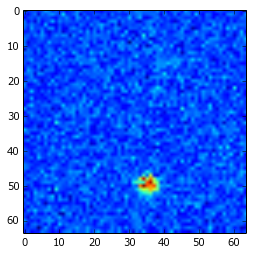

(32, 64, 64, 4)


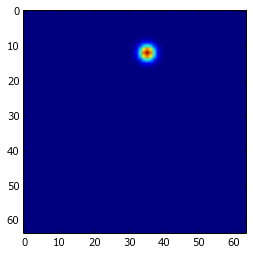

(32, 4, 2)


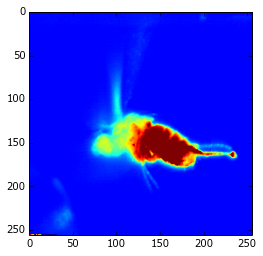

In [8]:
print(out[0].shape)
plt.imshow(out[0][1,:,:,0])
plt.show()
print(labelims.shape)
plt.imshow(labelims[1,:,:,0])
plt.show()
plt.imshow(batch_xs[1,0,:,:])
print(locs.shape)

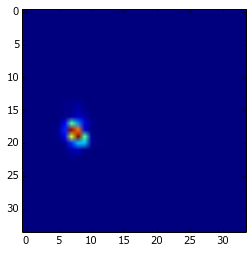

In [1]:
import h5py
import numpy as np
import stephenHeadConfig as conf
import PoseTools
reload(PoseTools)
import matplotlib.pyplot as plt
import tensorflow as tf

L = h5py.File(conf.labelfile)
pts = np.array(L['pts'])
ff = PoseTools.initMRFweights(conf)
ff.shape
plt.imshow(ff[:,:,0,1])
gg1 = tf.get_variable('dd',initializer=tf.constant(ff[:,:,0:0+1,1]))
gg2 = tf.get_variable('dd1',initializer=tf.constant(ff[:,:,1:1+1,1]))

kk = gg1+gg2+0
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
yy = kk.eval()

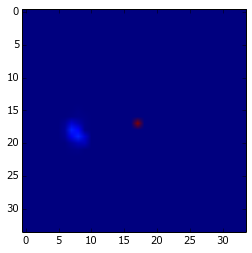

In [2]:
yy.shape
plt.imshow(yy[:,:,0] )

In [9]:
vvs = tf.trainable_variables()
for vv in vvs:
    print(vv.name,tf.Variable.get_shape(vv))

(u'dd:0', TensorShape([Dimension(34), Dimension(34), Dimension(5), Dimension(5)]))
